<a href="https://colab.research.google.com/github/yasaswini2004/ECG-Arrhythmia-Detection-using-Machine-Learning/blob/main/ECG_Arrhythmia_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

BASE_PATH = "/content/drive/MyDrive/ecg"

folders = [
    BASE_PATH,
    f"{BASE_PATH}/data",
    f"{BASE_PATH}/data/mitdb",
    f"{BASE_PATH}/models",
    f"{BASE_PATH}/results",
    f"{BASE_PATH}/notebooks",
    f"{BASE_PATH}/plots"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("✅ All folders created at:", BASE_PATH)


✅ All folders created at: /content/drive/MyDrive/ecg


In [ ]:
!pip install wfdb numpy scipy matplotlib pandas scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
import wfdb
import os

MIT_PATH = "/content/drive/MyDrive/ecg/data/mitdb"

wfdb.dl_database('mitdb', dl_dir=MIT_PATH)

print("✅ Dataset downloaded into:", MIT_PATH)
print("Sample files:", os.listdir(MIT_PATH)[:10])


Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


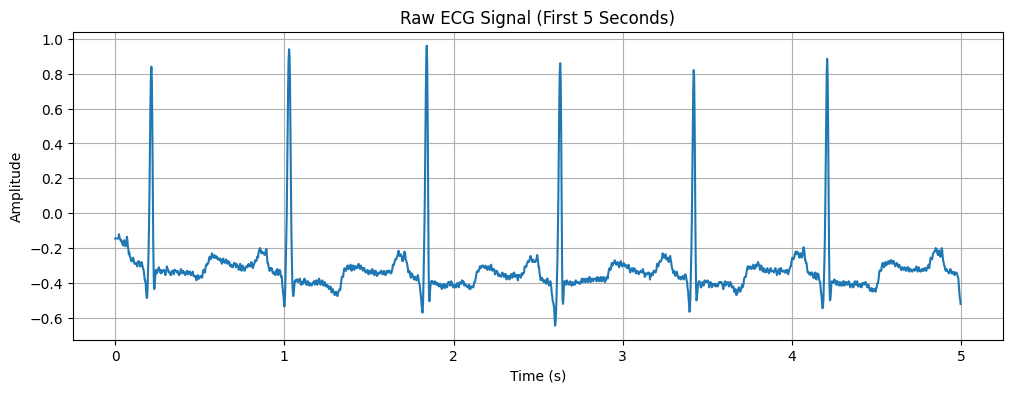

In [ ]:
BASE_PATH = "/content/drive/MyDrive/ecg"
MIT_PATH = f"{BASE_PATH}/data/mitdb"

record = wfdb.rdrecord(f"{MIT_PATH}/100")
fs = record.fs
signal = record.p_signal[:, 0]

seconds = 5
num_samples = int(seconds * fs)

plt.figure(figsize=(12,4))
plt.plot(np.arange(num_samples)/fs, signal[:num_samples])
plt.title("Raw ECG Signal (First 5 Seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.savefig(f"{BASE_PATH}/plots/raw_ecg.png")
plt.show()


In [ ]:
def extract_features_from_record(record_id, base_dir, window=5):
    rec_path = os.path.join(base_dir, str(record_id))

    record = wfdb.rdrecord(rec_path)
    ann = wfdb.rdann(rec_path, 'atr')

    fs = record.fs
    samples = np.array(ann.sample)
    symbols = np.array(ann.symbol)

    # RR intervals
    rr_intervals = np.diff(samples) / fs

    X, y = [], []

    for i in range(window, len(rr_intervals) - window):
        symbol = symbols[i+1]

        if symbol in ['|','~','+','!','[',']','"','x']:
            continue

        # Sliding window RR values
        rr_win = rr_intervals[i-window:i+window]

        # HRV features
        rr_mean = np.mean(rr_win)
        rr_std = np.std(rr_win)
        rr_min = np.min(rr_win)
        rr_max = np.max(rr_win)
        rr_range = rr_max - rr_min

        hr = 60 / rr_mean if rr_mean > 0 else 0

        features = [
            rr_mean,
            rr_std,
            rr_min,
            rr_max,
            rr_range,
            hr
        ]

        label = 0 if symbol == 'N' else 1

        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)


In [ ]:
record_ids = [100,101,102,103,104,105,106,107]

all_X, all_y = [], []

for rid in record_ids:
    print("Processing:", rid)
    Xr, yr = extract_features_from_record(rid, MIT_PATH)
    all_X.append(Xr)
    all_y.append(yr)

X = np.vstack(all_X)
y = np.concatenate(all_y)

print("✅ Total samples:", X.shape[0])
print("✅ Features per sample:", X.shape[1])
print("✅ Class distribution:", np.bincount(y))


Processing: 100
Processing: 101
Processing: 102
Processing: 103
Processing: 104
Processing: 105
Processing: 106
Processing: 107
✅ Total samples: 17295
✅ Features per sample: 6
✅ Class distribution: [10429  6866]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (13836, 6)
Test size: (3459, 6)


In [ ]:
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=14,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("✅ HRV-based model trained")


✅ HRV-based model trained


In [ ]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print("✅ Accuracy:", round(acc*100,2), "%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Arrhythmia"]))


✅ Accuracy: 89.04 %

Confusion Matrix:
 [[1793  293]
 [  86 1287]]

Classification Report:

              precision    recall  f1-score   support

      Normal       0.95      0.86      0.90      2086
  Arrhythmia       0.81      0.94      0.87      1373

    accuracy                           0.89      3459
   macro avg       0.88      0.90      0.89      3459
weighted avg       0.90      0.89      0.89      3459



In [ ]:
results_path = f"{BASE_PATH}/results/metrics.txt"

with open(results_path, "w") as f:
    f.write(f"Accuracy: {acc*100:.2f}%\n")

print("✅ Metrics saved to:", results_path)


✅ Metrics saved to: /content/drive/MyDrive/ecg/results/metrics.txt


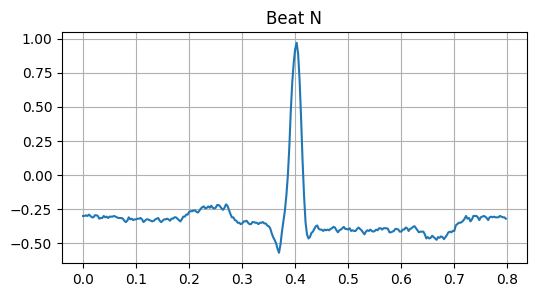

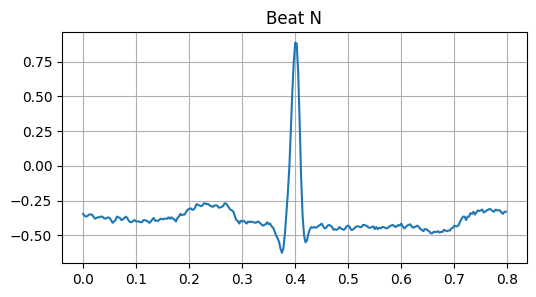

In [ ]:
def plot_beat(record_id, idx):
    rec = wfdb.rdrecord(f"{MIT_PATH}/{record_id}")
    ann = wfdb.rdann(f"{MIT_PATH}/{record_id}", 'atr')

    fs = rec.fs
    signal = rec.p_signal[:,0]

    r = ann.sample[idx]
    win = int(0.4 * fs)

    start, end = r-win, r+win
    seg = signal[start:end]
    t = np.arange(len(seg)) / fs

    plt.figure(figsize=(6,3))
    plt.plot(t, seg)
    plt.title(f"Beat {ann.symbol[idx]}")
    plt.grid(True)
    plt.savefig(f"{BASE_PATH}/plots/beat_{idx}.png")
    plt.show()

plot_beat(100, 20)
plot_beat(100, 40)
